In [1]:
import torch
from torchvision import datasets, transforms
from tqdm import trange
import matplotlib.pyplot as plt
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class PCA(object):
    def __init__(self, k):
        self.k = k
        self.mean = None
        self.V = None
    
    def fit(self, X):
        X = X.to(device)
        X_mean = torch.mean(X, dim=0)
        X = X - X_mean
        self.mean = X_mean
        U, S, self.V = torch.svd(X)
        self.V = self.V[:, :self.k].to(device)
        
    def transform(self, X):
        X = X.to(device)
        return torch.mm(X - self.mean, self.V)
    
    def fit_transform(self, X):
        X = X.to(device)
        self.fit(X)
        return self.transform(X)

In [3]:
def load_data(train: bool):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    dataset = datasets.MNIST(root='./data', train=train, download=False, transform=transform)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=train)
    
    datas, labels = zip(*(
        (data.view(data.shape[0], -1), target)
           for data, target in loader
    ))
    datas = torch.cat(datas, dim=0)
    labels = torch.cat(labels, dim=0)
    datas = datas.to(device)
    labels = labels.to(device)
    return datas, labels

In [4]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = torch.zeros(10, device=device)
        self.likelihoods = torch.zeros((10, 28 * 28), device=device)
        self.feature_counts = torch.zeros((10, 28 * 28), device=device)
        self.class_counts = torch.zeros(10, device=device)

    def fit(self, X, y):
        X, y = X.to(device), y.to(device)
        for i in range(10):
            class_images = X[y == i]
            self.feature_counts[i] += class_images.sum(dim=0)
            self.class_counts[i] += class_images.shape[0]
        
        self.class_priors = self.class_counts / self.class_counts.sum()
        self.likelihoods = (self.feature_counts + 1) / (self.class_counts.view(-1, 1) + 10)

    def predict(self, X):
        log_priors = torch.log(self.class_priors).to(device)
        log_likelihoods = torch.log(self.likelihoods).to(device)
        log_posterior = log_priors + X @ log_likelihoods.T
        return torch.argmax(log_posterior, dim=1)

In [5]:
class GaussianNaiveBayesClassifier(nn.Module):
    def __init__(self):
        super(GaussianNaiveBayesClassifier, self).__init__()
        self.classes = None
        self.class_prior = None
        self.mean = None
        self.var = None

    def fit(self, X, y):
        X, y = X.to(device), y.to(device)
        self.classes = torch.unique(y)
        self.class_prior = torch.zeros(len(self.classes), device=device)
        self.mean = torch.zeros(len(self.classes), X.shape[1], device=device)
        self.var = torch.zeros(len(self.classes), X.shape[1], device=device)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_prior[idx] = X_c.shape[0] / X.shape[0]
            self.mean[idx, :] = torch.mean(X_c, dim=0)
            self.var[idx, :] = torch.var(X_c, dim=0)
        
    def predict(self, X):
        X = X.to(device)
        log_posterior = torch.zeros(X.shape[0], len(self.classes), device=device)
        for idx, c in enumerate(self.classes):
            prior = torch.log(self.class_prior[idx])
            log_likelihood = -0.5 * torch.sum(torch.log(2 * torch.pi * self.var[idx, :]) + ((X - self.mean[idx, :]) ** 2) / self.var[idx, :], dim=1)
            log_posterior[:, idx] = prior + log_likelihood
        return torch.argmax(log_posterior, dim=1)

In [6]:
def ask_acc(classifier, k=-1):
    if k != -1:
        pca_model = PCA(k)
        pca_model.fit(train_data)
        train_data_pca = pca_model.transform(train_data)
        test_data_pca = pca_model.transform(test_data)
    else:
        train_data_pca = train_data.clone()
        test_data_pca = test_data.clone()
    classifier.fit(train_data_pca, train_labels)
    predictions = classifier.predict(test_data_pca)
    accuracy = (predictions == test_labels).float().mean()
    return accuracy

def acc_k_function(classifier, l:int=1, r:int=torch.inf, step:int=1):
    acc = []
    for k in trange(l, r, step):
        acc.append(ask_acc(classifier, k).cpu())
    plt.plot(range(l, r, step), acc)
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()

In [7]:
train_data, train_labels = load_data(True)
test_data, test_labels = load_data(False)

In [8]:
nb_classifier = NaiveBayesClassifier()
display(ask_acc(nb_classifier))
gb_classifier = GaussianNaiveBayesClassifier()
display(ask_acc(gb_classifier))
display(ask_acc(gb_classifier, 69))

tensor(0.0980, device='cuda:0')

tensor(0.8830, device='cuda:0')

100%|██████████| 70/70 [00:27<00:00,  2.56it/s]


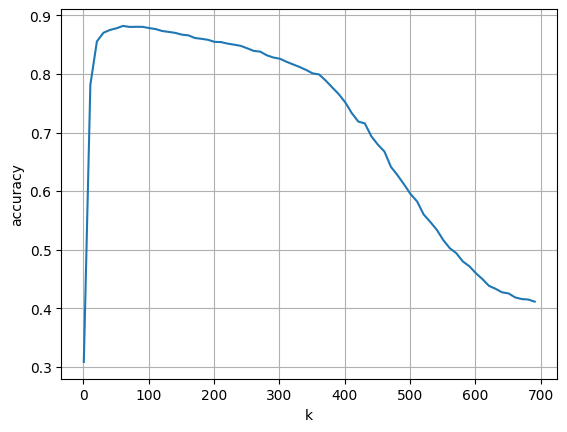

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


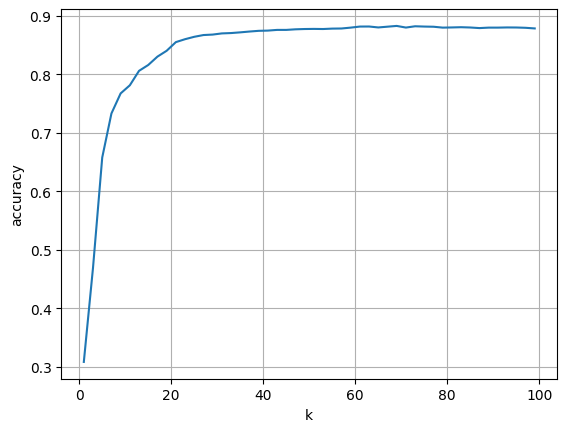

100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


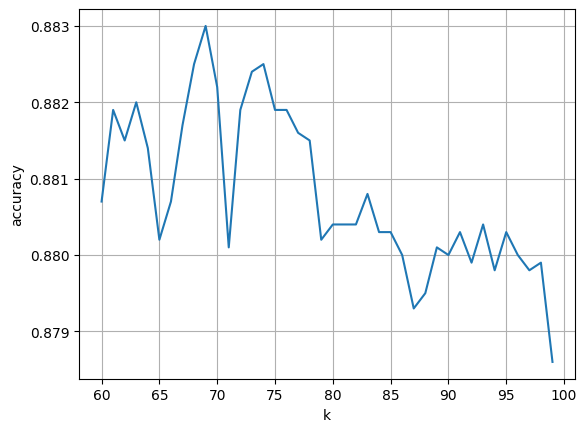

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


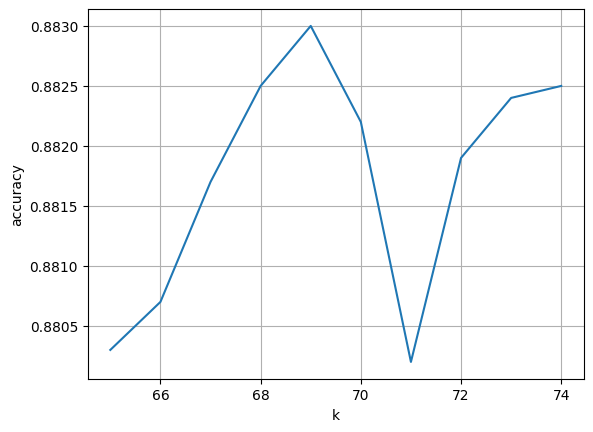

In [9]:
acc_k_function(gb_classifier, 1, 700, 10)
acc_k_function(gb_classifier, 1, 100, 2)
acc_k_function(gb_classifier, 60, 100, 1)
acc_k_function(gb_classifier, 65, 75, 1)